In [1]:
import numpy as np
import cupy as cp
import time

N = 1024

# --- CPU ---
A_cpu = np.random.rand(N, N).astype(np.float32)
B_cpu = np.random.rand(N, N).astype(np.float32)

start = time.time()
C_cpu = np.matmul(A_cpu, B_cpu)
end = time.time()
print(f"Mnożenie macierzy na CPU trwało: {end - start:.5f} s")

# --- GPU (CuPy) ---
A_gpu = cp.array(A_cpu)
B_gpu = cp.array(B_cpu)

start = time.time()
C_gpu = cp.matmul(A_gpu, B_gpu)
cp.cuda.Stream.null.synchronize()
end = time.time()
print(f"Mnożenie macierzy na GPU trwało: {end - start:.5f} s")

Mnożenie macierzy na CPU trwało: 0.07342 s
Mnożenie macierzy na GPU trwało: 0.91102 s


In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install pycuda

import numpy as np
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import time

# Kernel CUDA
kernel_code = """
__global__ void matrixMul(float *A, float *B, float *C, int N) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;
    float sum = 0.0;
    if (row < N && col < N) {
        for (int k = 0; k < N; k++) {
            sum += A[row * N + k] * B[k * N + col];
        }
        C[row * N + col] = sum;
    }
}
"""

N = 1024

A_cpu = np.random.rand(N, N).astype(np.float32)
B_cpu = np.random.rand(N, N).astype(np.float32)
C_cpu = np.empty((N, N), np.float32)

mod = SourceModule(kernel_code)
matrixMul = mod.get_function("matrixMul")

A_gpu = cuda.mem_alloc(A_cpu.nbytes)
B_gpu = cuda.mem_alloc(B_cpu.nbytes)
C_gpu = cuda.mem_alloc(C_cpu.nbytes)

cuda.memcpy_htod(A_gpu, A_cpu)
cuda.memcpy_htod(B_gpu, B_cpu)

block_size = (32, 32, 1)
grid_size = (int(N / 32), int(N / 32), 1)

start = time.time()
matrixMul(A_gpu, B_gpu, C_gpu, np.int32(N), block=block_size, grid=grid_size)
cuda.Context.synchronize()
end = time.time()

cuda.memcpy_dtoh(C_cpu, C_gpu)
print(f"Mnożenie macierzy (PyCUDA) trwało: {end - start:.5f} s")

del A_gpu, B_gpu, C_gpu

LogicError: cuModuleLoadDataEx failed: an illegal memory access was encountered - 

In [2]:

import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import time

sizes = [256, 512, 768, 1024]
cupy_times = []

for N in sizes:
    print(f"\n🔹 Test dla N = {N}")

    A = np.random.rand(N, N).astype(np.float32)
    B = np.random.rand(N, N).astype(np.float32)

    A_gpu = cp.array(A)
    B_gpu = cp.array(B)
    start = time.time()
    C_gpu = cp.matmul(A_gpu, B_gpu)
    cp.cuda.Stream.null.synchronize()
    end = time.time()
    cupy_times.append(end - start)

    del A_gpu, B_gpu, C_gpu
    cp._default_memory_pool.free_all_blocks()





🔹 Test dla N = 256

🔹 Test dla N = 512

🔹 Test dla N = 768

🔹 Test dla N = 1024


In [4]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install pycuda

import numpy as np
import matplotlib.pyplot as plt
import time
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import cupy as cp

kernel_code = """
__global__ void matrixMul(float *A, float *B, float *C, int N) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;
    float sum = 0.0;
    if (row < N && col < N) {
        for (int k = 0; k < N; k++) {
            sum += A[row * N + k] * B[k * N + col];
        }
        C[row * N + col] = sum;
    }
}
"""
mod = SourceModule(kernel_code)
matrixMul = mod.get_function("matrixMul")


sizes = [256, 512, 768, 1024]
pycuda_times = []

for N in sizes:
    print(f"🔹 PyCUDA: test dla N = {N}")
    A = np.random.rand(N, N).astype(np.float32)
    B = np.random.rand(N, N).astype(np.float32)
    C = np.empty((N, N), dtype=np.float32)


    A_gpu = cuda.mem_alloc(A.nbytes)
    B_gpu = cuda.mem_alloc(B.nbytes)
    C_gpu = cuda.mem_alloc(C.nbytes)


    cuda.memcpy_htod(A_gpu, A)
    cuda.memcpy_htod(B_gpu, B)


    block_size = (32, 32, 1)
    grid_size = (int(N / 32), int(N / 32), 1)


    start = time.time()
    matrixMul(A_gpu, B_gpu, C_gpu, np.int32(N), block=block_size, grid=grid_size)
    cuda.Context.synchronize()
    end = time.time()
    pycuda_times.append(end - start)

    del A_gpu, B_gpu, C_gpu
    cp._default_memory_pool.free_all_blocks()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 28.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 11.1 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2025.1.2-cp312-cp312-linux_x86_64.whl size=659050 sha256=190456fd85521223cfcb7224744d14e09e486b7759c7eb83efdc26c7963e51c1
  Stored in directory: /root/.cache/pip/wheels/d5/36/f3/ac5f09d768cad3fa15d5a3449bdfe65c3de58e69d036c73228
Successfully built pycuda
🔹 PyCUDA: test dla N = 256
🔹 PyCUDA: test dla N = 512
🔹 PyCUDA: test dla N = 768
🔹 PyCUDA: test dla N = 1024


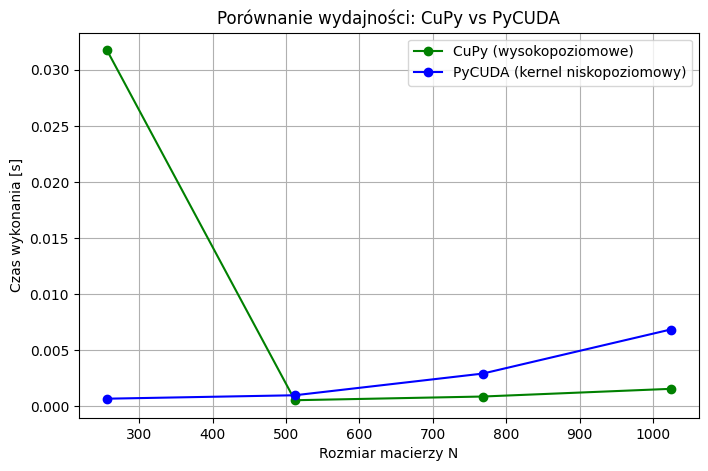

In [5]:
plt.figure(figsize=(8,5))
plt.plot(sizes, cupy_times, 'g-o', label='CuPy (wysokopoziomowe)')
plt.plot(sizes, pycuda_times, 'b-o', label='PyCUDA (kernel niskopoziomowy)')
plt.xlabel("Rozmiar macierzy N")
plt.ylabel("Czas wykonania [s]")
plt.title("Porównanie wydajności: CuPy vs PyCUDA")
plt.legend()
plt.grid(True)
plt.show()